## Dependencies

In [270]:
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Importing the data

Fetch DOW ticker from yfinance

In [271]:
dow = yf.Ticker('^DJI')

Obtain trading history

In [272]:
dow = dow.history(period='max')
dow

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1992-01-02 00:00:00-05:00,3152.100098,3172.629883,3139.310059,3172.399902,23550000,0.0,0.0
1992-01-03 00:00:00-05:00,3172.399902,3210.639893,3165.919922,3201.500000,23620000,0.0,0.0
1992-01-06 00:00:00-05:00,3201.500000,3213.330078,3191.860107,3200.100098,27280000,0.0,0.0
1992-01-07 00:00:00-05:00,3200.100098,3210.199951,3184.479980,3204.800049,25510000,0.0,0.0
1992-01-08 00:00:00-05:00,3204.800049,3229.199951,3185.820068,3203.899902,29040000,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-26 00:00:00-05:00,37405.898438,37617.988281,37371.828125,37545.328125,212420000,0.0,0.0
2023-12-27 00:00:00-05:00,37518.621094,37683.699219,37488.601562,37656.519531,245530000,0.0,0.0
2023-12-28 00:00:00-05:00,37661.519531,37778.851562,37650.980469,37710.101562,199550000,0.0,0.0


In [283]:
columns = list(dow)

dow = dow[columns].astype(float)

## Cleaning data and visualizing

Plot closing price over time

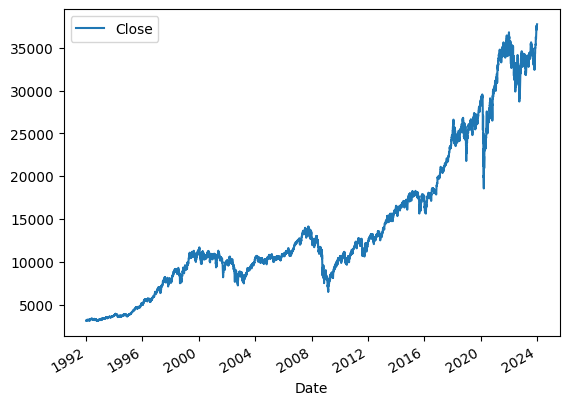

In [284]:
dow.plot.line(y='Close', use_index=True)
plt.show()

Create column for stock prices of tomorrow

In [255]:
dow['Tomorrow'] = dow['Close'].shift(-1)

Create target variables for whether price increases tomorrow

In [256]:
dow['Target'] = (dow['Tomorrow'] > dow['Close']).astype(int)
dow.head()

,Close,Tomorrow,Target
Date,,,
1992-01-02 00:00:00-05:00,3172.399902,3201.500000,1
1992-01-03 00:00:00-05:00,3201.500000,3200.100098,0
1992-01-06 00:00:00-05:00,3200.100098,3204.800049,1
1992-01-07 00:00:00-05:00,3204.800049,3203.899902,0
1992-01-08 00:00:00-05:00,3203.899902,3209.500000,1


## Training machine learning models

### Functions

Prediction function

In [257]:
def predict(train, test, predictors, model):
    # fit model
    model.fit(X=train[predictors], y=train['Target'])
    # obtain class probabilities
    predictions = model.predict_proba(X=test[predictors])[:, 1]
    # convert to labels with more confidence
    predictions[predictions >= 0.55] = 1
    predictions[predictions < 0.55] = 0
    # convert to pd Series
    predictions = pd.Series(predictions, index=test.index, name='Predictions')
    # combine predictions with targets
    return pd.concat([test['Target'], predictions], axis=1)

Backtesting to create train/test splits using years up to $i$ to predict on year $i+1$

In [258]:
def backtest(data, model, predictors, start=2500, step=250):
    
    all_predictions = []
    num_rows = data.shape[0]
    
    for i in tqdm(range(start, num_rows, step)):
        # train-test split
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        # obtain predictions
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

Function to return precision, recall and F1

In [259]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def metrics(y_true, y_pred):
    return precision_score(y_true, y_pred), recall_score(y_true, y_pred), f1_score(y_true, y_pred)

def print_metrics(precision, recall, f1):
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

Create features for data (trends, rolling averages)

In [260]:
# time in days
time_windows = [3, 10, 30, 60, 300, 1000]
predictors = []

for time_window in time_windows:
    rolling_avgs = dow.rolling(time_window).mean()
    
    ratio_column_name = f'Close_Ratio_{time_window}'
    dow[ratio_column_name] = dow['Close'] / rolling_avgs['Close']
    
    # num of days where stock price went up
    trend_column_name = f'Trend_{time_window}'
    dow[trend_column_name] = dow.shift(1).rolling(time_window).sum()['Target']
    
    predictors += [ratio_column_name, trend_column_name]

dow = dow.dropna()
dow.head()

,Close,Tomorrow,Target,Close_Ratio_3,Trend_3,Close_Ratio_10,Trend_10,Close_Ratio_30,Trend_30,Close_Ratio_60,Trend_60,Close_Ratio_300,Trend_300,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,
1995-12-14 00:00:00-05:00,5182.149902,5176.729980,0,0.998260,1.0,1.002790,6.0,1.032557,21.0,1.059507,35.0,1.193538,166.0,1.378068,538.0
1995-12-15 00:00:00-05:00,5176.729980,5075.209961,0,0.997101,1.0,1.000007,5.0,1.028961,20.0,1.056925,35.0,1.191050,165.0,1.375904,537.0
1995-12-18 00:00:00-05:00,5075.209961,5109.890137,1,0.986494,0.0,0.981615,4.0,1.007116,19.0,1.035102,35.0,1.166620,164.0,1.348250,537.0
1995-12-19 00:00:00-05:00,5109.890137,5059.319824,0,0.997907,1.0,0.989616,4.0,1.012017,20.0,1.040972,35.0,1.173482,165.0,1.356776,537.0
1995-12-20 00:00:00-05:00,5059.319824,5096.529785,1,0.995640,1.0,0.982483,3.0,1.000270,20.0,1.029644,35.0,1.160829,164.0,1.342687,537.0


### Random forest

In [261]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, min_samples_split=40, random_state=1)

predictions = backtest(dow, rf, predictors)

rf_precision, rf_recall, rf_f1 = metrics(y_true=predictions['Target'], y_pred=predictions['Predictions'])
print_metrics(rf_precision, rf_recall, rf_f1)

100%|██████████| 19/19 [01:20<00:00,  4.25s/it]

Precision: 0.53700414446418
Recall: 0.3685493701747257
F1: 0.4371084337349397


### LSTM

In [266]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dow[predictors + ['Target']])

# sequences for LSTM
def create_sequences(data, seq_length):
    
    xs = []
    ys = []
    
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length), :-1]
        y = data[i + seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 100
X, y = create_sequences(scaled_data, seq_length)


In [267]:
def predict_lstm(model, data):
    # reshape for LSTM (samples, time steps, features)
    data = data.reshape((data.shape[0], data.shape[1], len(predictors)))
    # obtain predictions
    predictions = model.predict(data)
    # convert predictions to binary with higher confidence
    predictions = (predictions >= 0.65).astype(int)
    return predictions.flatten()


In [268]:
# train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# build LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(X_train, y_train, batch_size=32, epochs=100)


Epoch 1/100
174/174 [==============================] - 8s 30ms/step - loss: 0.6932
Epoch 2/100
174/174 [==============================] - 5s 30ms/step - loss: 0.6919
Epoch 3/100
174/174 [==============================] - 5s 31ms/step - loss: 0.6919
Epoch 4/100
174/174 [==============================] - 5s 30ms/step - loss: 0.6918
Epoch 5/100
174/174 [==============================] - 5s 30ms/step - loss: 0.6920
Epoch 6/100
174/174 [==============================] - 6s 32ms/step - loss: 0.6917
Epoch 7/100
174/174 [==============================] - 6s 32ms/step - loss: 0.6918
Epoch 8/100
174/174 [==============================] - 5s 31ms/step - loss: 0.6915
Epoch 9/100
174/174 [==============================] - 5s 30ms/step - loss: 0.6916
Epoch 10/100
174/174 [==============================] - 5s 31ms/step - loss: 0.6916
Epoch 11/100
174/174 [==============================] - 5s 31ms/step - loss: 0.6918
Epoch 12/100
174/174 [==============================] - 5s 31ms/step - loss: 0.6917
E

In [269]:
# predict and evaluate
predictions = predict_lstm(model, X_test)
precision, recall, f1 = metrics(y_test, predictions)
print_metrics(precision, recall, f1)


44/44 [==============================] - 1s 11ms/step
Precision: 0.5555555555555556
Recall: 0.006613756613756613
F1: 0.0130718954248366
